# WaveTilts Class [v2.1]

In [1]:
%matplotlib inline

In [2]:
# imports
import os
import numpy as np
from importlib import reload

from astropy.table import Table

from pypit import wavetilts

In [3]:
# Path to PYPIT-Development-suite
pypdev_path = os.getenv('PYPIT_DEV')

# Users

## We recommend you use the pypit_chk_tilts script to view the outputs and the QA to check the RMS residuals

### Here are a few of examples

        pypit_chk_tilts fweight A_01_aa --slit 0
        pypit_chk_tilts model A_01_aa --slit 0
        pypit_chk_tilts tilts A_01_aa --slit 0

----

# Development

In [4]:
from pypit import traceslits
from pypit import arcimage

## Load up required MasterFrames

In [5]:
settings = dict(masters={})
settings['masters']['directory'] = pypdev_path+'/Cooked/MF_shane_kast_blue'
settings['masters']['reuse'] = True

In [6]:
setup = 'A_01_aa'

### MasterArc

In [7]:
AImg = arcimage.ArcImage(setup=setup, settings=settings)
msarc, header, _ = AImg.load_master_frame()

[WARNING] :: processimages.py 97 __init__() - No information on the spectrograph was given.  Do not attempt to (re)process the images
[INFO]    :: armasters.py 241 _load() - Loading a pre-existing master calibration frame


### TraceSlits

In [8]:
TSlits = traceslits.TraceSlits.from_master_files(settings['masters']['directory']+'/MasterTrace_A_01_aa')
TSlits._make_pixel_arrays()

[INFO]    :: traceslits.py 207 from_master_files() - Loading BPM from /home/xavier/local/Python/PYPIT-development-suite//Cooked/MF_shane_kast_blue/MasterTrace_A_01_aa.fits.gz
[INFO]    :: traceslits.py 518 _make_pixel_arrays() - Converting physical trace locations to nearest pixel
[INFO]    :: traceslits.py 525 _make_pixel_arrays() - Identifying the pixels belonging to each slit


----

## Init WaveTilts

In [9]:
reload(wavetilts)
settings_det = dict(det01={'saturation': 60000., 'nonlinear': 0.9})
waveTilts = wavetilts.WaveTilts(msarc, det=1, setup=setup, rordloc=TSlits.rcen, lordloc=TSlits.lcen, 
                             pixlocn=TSlits.pixlocn, pixcen=TSlits.pixcen, settings_det=settings_det)

[WARNING] :: masterframe.py 57 __init__() - MasterFrame class not fully loaded (e.g. no masters in settings).  Avoid using Master methods


## Extract arcs -- Requires msarc and slit info

In [10]:
arccen, maskslits = waveTilts._extract_arcs()

[INFO]    :: ararc.py 85 get_censpec() - Extracting an approximate arc spectrum at the centre of each slit


In [11]:
arccen.shape

(2048, 1)

## Tilts in this slit

In [12]:
slit=0

In [13]:
waveTilts.settings['tilts']['trthrsh'] = 500.  # Lowers the thershold amplitude of the arc lines used

trcdict = waveTilts._trace_tilts(slit)

[WORK IN ]::
[PROGRESS]:: artracewave.py 205 trace_tilt() - Detecting lines for slit 1
[INFO]    :: ararc.py 177 detect_lines() - Detecting lines
[INFO]    :: ararc.py 203 detect_lines() - Detecting the strongest, nonsaturated lines
[INFO]    :: artracewave.py 263 trace_tilt() - Modelling arc line tilts with 13 arc lines
[WORK IN ]::
[PROGRESS]:: artracewave.py 269 trace_tilt() - This next step could be multiprocessed to speed up the reduction
[INFO]    :: artracewave.py 467 trace_tilt() - Completed spectral tilt tracing


### Show

In [14]:
waveTilts.show('sslit', slit=slit)

## Analyze the tilt traces in a single slit

In [15]:
waveTilts.settings['tilts']['order'] = 3

In [16]:
badrows = waveTilts._analyze_lines(slit)
badrows

0

In [17]:
waveTilts.show('model', slit=slit)

## Fit Tilts

In [18]:
waveTilts.all_trcdict[0]['arcdet']

array([  43,  168,  202,  245,  259,  496,  637,  658,  689,  804,  948,
        956,  967,  996, 1020, 1077, 1222, 1259, 1274, 1307, 1389, 1503,
       1590, 1655, 1718, 1998])

In [19]:
#mtilt = waveTilts.all_tilts[3]
#mtilt[:,0] * (waveTilts.msarc.shape[0]-1)

In [20]:
waveTilts.settings['tilts']['yorder'] = 4
waveTilts.settings['tilts']['func2D'] = 'legendre'

[INFO]    :: artracewave.py 808 fit_tilts() - Fitting tilts with a low order, 2D legendre
[WORK IN ]::
[PROGRESS]:: arutils.py 631 polyfit2d_general() - Generalize to different polynomial types
[INFO]    :: artracewave.py 824 fit_tilts() - RMS (pixels): 0.005149363478861173


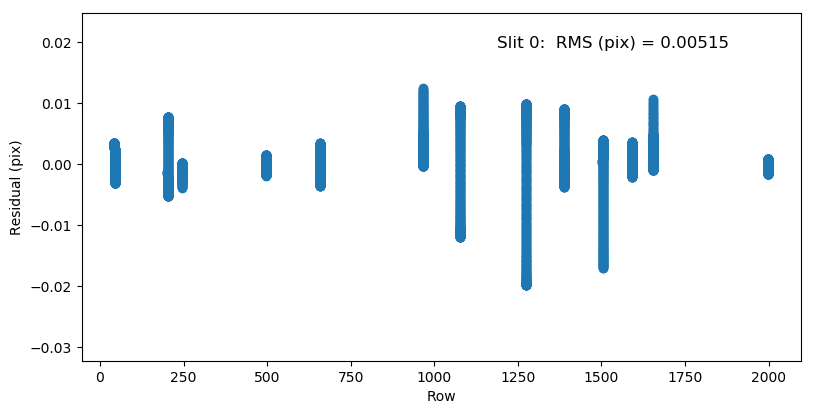

In [21]:
polytilts = waveTilts._fit_tilts(slit, show_QA=True)

### Show image

In [22]:
waveTilts.show('tilt_img' )

### Show on arc lines

In [23]:
waveTilts.show('tilts', slit=slit)

[WARNING] :: wavetilts.py 402 show() - Display via tilts is not exact


## Save

In [24]:
waveTilts.final_tilts = waveTilts.tilts

In [25]:
waveTilts.save_master(outfile='tmp.fits')

----

# DEIMOS long-slit

In [26]:
from pypit import traceslits
from pypit import arcimage

In [27]:
# Master frames
settings = dict(masters={})
settings['masters']['directory'] = pypdev_path+'/REDUX_OUT/Keck_DEIMOS/830G_L/MF_keck_deimos'
settings['masters']['reuse'] = True
setup = 'A_07_aa'

In [28]:
AImg = arcimage.ArcImage(setup=setup, settings=settings)
msarc, header, _ = AImg.load_master_frame()
#
TSlits = traceslits.TraceSlits.from_master_files(settings['masters']['directory']+'/MasterTrace_A_07_aa')
TSlits._make_pixel_arrays()

[WARNING] :: processimages.py 97 __init__() - No information on the spectrograph was given.  Do not attempt to (re)process the images
[INFO]    :: armasters.py 241 _load() - Loading a pre-existing master calibration frame
[INFO]    :: traceslits.py 207 from_master_files() - Loading BPM from /home/xavier/local/Python/PYPIT-development-suite//REDUX_OUT/Keck_DEIMOS/830G_L/MF_keck_deimos/MasterTrace_A_07_aa.fits.gz
[INFO]    :: traceslits.py 518 _make_pixel_arrays() - Converting physical trace locations to nearest pixel
[INFO]    :: traceslits.py 525 _make_pixel_arrays() - Identifying the pixels belonging to each slit


----

## DEIMOS BEGINS HERE

### Instantiate

In [29]:
reload(wavetilts)
settings_det = dict(det07={'saturation': 60000., 'nonlinear': 0.9})
wTiltD = wavetilts.WaveTilts(msarc, det=7, setup=setup, rordloc=TSlits.rcen, lordloc=TSlits.lcen, 
                             pixlocn=TSlits.pixlocn, pixcen=TSlits.pixcen, settings_det=settings_det)

[WARNING] :: masterframe.py 57 __init__() - MasterFrame class not fully loaded (e.g. no masters in settings).  Avoid using Master methods


### Extract

In [30]:
arccen, maskslits = wTiltD._extract_arcs()

[INFO]    :: ararc.py 85 get_censpec() - Extracting an approximate arc spectrum at the centre of each slit


### Trace

In [31]:
slit=0
wTiltD.settings['tilts']['trthrsh'] = 400.

In [32]:
# Trace tilts
trcdict = wTiltD._trace_tilts(slit)

[WORK IN ]::
[PROGRESS]:: artracewave.py 205 trace_tilt() - Detecting lines for slit 1
[INFO]    :: ararc.py 177 detect_lines() - Detecting lines
[INFO]    :: ararc.py 203 detect_lines() - Detecting the strongest, nonsaturated lines
[INFO]    :: artracewave.py 263 trace_tilt() - Modelling arc line tilts with 28 arc lines
[WORK IN ]::
[PROGRESS]:: artracewave.py 269 trace_tilt() - This next step could be multiprocessed to speed up the reduction
[INFO]    :: artracewave.py 467 trace_tilt() - Completed spectral tilt tracing


In [33]:
waveTilts.show('sslit', slit=slit)

### Analyze tilts

In [34]:
waveTilts.settings['tilts']['order'] = 3
badrows = wTiltD._analyze_lines(slit)
badrows

[WARNING] :: wavetilts.py 151 _analyze_lines() - There were 2 additional arc lines that should have been traced
             (perhaps lines were saturated?). Check the spectral tilt solution


2

In [35]:
wTiltD.show('model', slit=slit)

### 2D Fit

In [36]:
waveTilts.settings['tilts']['yorder'] = 4
waveTilts.settings['tilts']['func2D'] = 'legendre'

[INFO]    :: artracewave.py 808 fit_tilts() - Fitting tilts with a low order, 2D legendre
[WORK IN ]::
[PROGRESS]:: arutils.py 631 polyfit2d_general() - Generalize to different polynomial types
[INFO]    :: artracewave.py 824 fit_tilts() - RMS (pixels): 0.01561645399475178


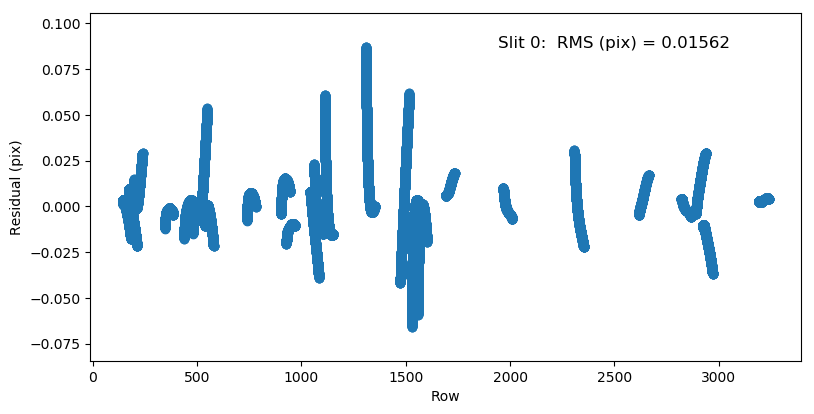

In [37]:
tilts = wTiltD._fit_tilts(slit, show_QA=True)

In [38]:
wTiltD.show('tilts', slit=slit)

[WARNING] :: wavetilts.py 402 show() - Display via tilts is not exact
